# Project - Part 2

### **The structure of the notebook is as follows:** 
- presenting [preliminary self-examination](#Preliminary-self-examination)  processes by stages on loaded data 
    - remove duplicate samples
    - careful outliers handling (that won't cause leakage)
    - feature engineering that does not depend on statistical data
    - omit irrelevant features (with explenation)
    - introduce explanations about functions that together make up the main `prepare_data()` function are detailed in that stage.
    
    
- arrange relevant functions and additional code within the [`prepare_data()` function](#prepare_data()-function)
- examine [feature importances and their affection](#Selecting-features-by-visual-charts-and-correlation) on the target and each other.
- [build a pipe-line preprocessor](#Building-an-external-(global)-preprocessor-consisting-of-pipelines-for-imputing-and-scaling) for an orderly process
- Build and train [Elastic-net regression model](#Build-and-train-Elastic-net-regression-model).
- conducting [10-fold-CV for validation](#10-Fold-Cross-validation-scores:).
- [inner check](#Inner-check-with-data-split-and-using-modified-function) with data train-test spliting.

#### To note:
- For the preprecessor OHE - the attribute 'sparse=False' may be in some versions 'sparse_output=False'.
- install relevant libraries.

In [3]:
# pip install category_encoders

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
import re
import math
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder ,RobustScaler, StandardScaler
from category_encoders import TargetEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from packaging import version
from sklearn.model_selection import train_test_split,cross_validate, cross_val_score, RepeatedKFold
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import chi2_contingency, spearmanr
from sklearn.preprocessing import KBinsDiscretizer
from scipy.stats import pointbiserialr
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_regression


In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
BOLD = '\033[1m'
RESET = '\033[0m'

* Guideline - since we are willing to use ElasticNet model, that knows to minimize and even nullify irrelevant features **by itself**, we'll give up on features only with cases of too many missing values, obvious inner multicollinearity or noticeable irrelevance.

# Preliminary self-examination 

In [9]:
original_data = pd.read_csv('dataset.csv')
data = original_data.copy()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   manufactor       1500 non-null   object 
 1   Year             1500 non-null   int64  
 2   model            1500 non-null   object 
 3   Hand             1500 non-null   int64  
 4   Gear             1499 non-null   object 
 5   capacity_Engine  1474 non-null   object 
 6   Engine_type      1495 non-null   object 
 7   Prev_ownership   774 non-null    object 
 8   Curr_ownership   774 non-null    object 
 9   Area             1361 non-null   object 
 10  City             1500 non-null   object 
 11  Price            1500 non-null   float64
 12  Pic_num          1476 non-null   float64
 13  Cre_date         1500 non-null   object 
 14  Repub_date       1500 non-null   object 
 15  Description      1500 non-null   object 
 16  Color            787 non-null    object 
 17  Km            

### Omit features with too many nulls: 

In [11]:
data = data.drop(columns = ['Prev_ownership','Curr_ownership','Color', 'Test', 'Supply_score'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   manufactor       1500 non-null   object 
 1   Year             1500 non-null   int64  
 2   model            1500 non-null   object 
 3   Hand             1500 non-null   int64  
 4   Gear             1499 non-null   object 
 5   capacity_Engine  1474 non-null   object 
 6   Engine_type      1495 non-null   object 
 7   Area             1361 non-null   object 
 8   City             1500 non-null   object 
 9   Price            1500 non-null   float64
 10  Pic_num          1476 non-null   float64
 11  Cre_date         1500 non-null   object 
 12  Repub_date       1500 non-null   object 
 13  Description      1500 non-null   object 
 14  Km               1412 non-null   object 
dtypes: float64(2), int64(2), object(11)
memory usage: 175.9+ KB


#### Assuming some specific features cannot be exactly identical for others in another cars - remove duplicates using `pd.drop_duplicates` keeping the first sample (for example - seller updated his ad and did not remove the previous).
* After that, well create feature of description's length as possible price estimator and omit this column using `desctiption_to_length` function since it no more useful. 

In [13]:
data = data.drop_duplicates(subset=['model','Year','Gear','Cre_date','Hand','Description'], keep = 'first')


In [14]:
def description_to_length(df):
    df['Description'] = df['Description'].apply(lambda x: x[1:-1].strip('\'\"[]'))
    df['Description_Length'] = df['Description'].apply(lambda x: len(x.split()))
    df.drop(columns = ['Description'], inplace = True)
    return df
data = description_to_length(data)

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1352 entries, 0 to 1499
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   manufactor          1352 non-null   object 
 1   Year                1352 non-null   int64  
 2   model               1352 non-null   object 
 3   Hand                1352 non-null   int64  
 4   Gear                1351 non-null   object 
 5   capacity_Engine     1331 non-null   object 
 6   Engine_type         1347 non-null   object 
 7   Area                1220 non-null   object 
 8   City                1352 non-null   object 
 9   Price               1352 non-null   float64
 10  Pic_num             1328 non-null   float64
 11  Cre_date            1352 non-null   object 
 12  Repub_date          1352 non-null   object 
 13  Km                  1284 non-null   object 
 14  Description_Length  1352 non-null   int64  
dtypes: float64(2), int64(3), object(10)
memory usage: 169.0

### Turn `Cre_date` and `Repub_date` features to binary.
* Instead of drop thses features we will create a binary feature - `Is_republicated` value is 1 if the ad was republicated and otherwise 0.
* After that, these features will be ommited.

In [17]:
def is_republicated(df):
    df['Is_republicated'] = (df['Cre_date'] == df['Repub_date']).astype(int)
    df.drop(columns = ['Cre_date', 'Repub_date'], inplace = True)
    return df
data = is_republicated(data)

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1352 entries, 0 to 1499
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   manufactor          1352 non-null   object 
 1   Year                1352 non-null   int64  
 2   model               1352 non-null   object 
 3   Hand                1352 non-null   int64  
 4   Gear                1351 non-null   object 
 5   capacity_Engine     1331 non-null   object 
 6   Engine_type         1347 non-null   object 
 7   Area                1220 non-null   object 
 8   City                1352 non-null   object 
 9   Price               1352 non-null   float64
 10  Pic_num             1328 non-null   float64
 11  Km                  1284 non-null   object 
 12  Description_Length  1352 non-null   int64  
 13  Is_republicated     1352 non-null   int32  
dtypes: float64(2), int32(1), int64(3), object(8)
memory usage: 153.2+ KB


### Omit `City` and `Area` features 
* Dropping those columns understanding that price of car from the north will not be different than price of the same car from the south or from any ather area (or city) around the country.
* Besides, this features' data is very dirty and demands a lot of work of cleaning.

In [20]:
data.drop(columns = ['City', 'Area'], inplace = True)

## Manufactor and Model:

In [22]:
data.model.unique()

array(['i35', 'ניסאן מיקרה', 'סוזוקי סוויפט', 'אוריס', 'פיקנטו',
       'אאודי A1', 'אימפרזה', 'ASX', '220', '525', 'מוקה', 'פורטה', ' Q3',
       'סיוויק סדאן', 'סוזוקי SX4 קרוסאובר', 'קורולה', 'גולף', 'פאסאט',
       'ספארק', 'מאזדה 3', 'ניסאן נוט', 'סול', 'V40 CC', 'לנסר ספורטבק',
       'i10', 'אאודי A3', ' A1', 'סקודה פאביה\r\n (2012)', 'אוקטביה',
       'CIVIC', 'איוניק', 'סונטה', 'i30', 'C-HR', 'מאליבו', 'ריו',
       'פוקוס', 'סקודה אוקטביה (2014)', 'X1', 'אוואו', 'סיוויק',
       'סקודה ראפיד (2015)', ' E-Class', ' S7', 'אפלנדר', 'SVX',
       'סוזוקי איגניס', 'ספייס סטאר', 'לקסוס IS300h', "גראנד, וויאג'ר",
       'C4', '2008', 'סטוניק', 'פולו', 'S60', 'אאודי RS5', "ג'אז הייבריד",
       'סוזוקי SX4', 'ג`טה', ' A4', 'אס-מקס', 'נירו', 'אינסייט',
       'רנו קליאו', '3', 'אאודי All Road', 'פאסאט CC', ' S-Class',
       'CADDY COMBI', 'אסטרה', 'XV', 'סיוויק סדאן החדשה', 'אאודי A5',
       '316', 'C3', 'סדרה 5', 'אקורד', 'i25', 'C1', 'יאריס',
       'לקסוס IS250', 'V40', 'סדרה 1',

* Total mess, let's clean it:

In [24]:
data['manufactor'] = data['manufactor'].str.replace('Lexsus', 'לקסוס')  # Match language

In [25]:
data['model'] = data['model'].str.strip()  # Remove whitespaces
data['model'] = data['model'].str.replace(r'\s+', ' ', regex=True)  # Replace multiple spaces with a single space
data['model'] = data['model'].str.replace(r'\r\n', '', regex=True) 
data['model'] = data['model'].str.replace('`', "'") 
data['model'] = data['model'].str.lower() # Convert to lowercase for consistency

# There are some cars samples' manufactor with repetitiveness in the manufactor and model features, lets clean them
unique_manufactors = data['manufactor'].unique().tolist()
for brand in unique_manufactors:
    data['model'] = data['model'].str.replace(brand, '', regex=False)   
    
# Strip again to remove any spaces resulted from the replacement
data['model'] = data['model'].str.strip()

# Remove the year in brackets - found in Skoda vehicles
data['model'] = data['model'].str.replace(r'\s*\(\d{4}\)', '', regex=True)

In [26]:
data.model.unique()

array(['i35', 'מיקרה', 'סוויפט', 'אוריס', 'פיקנטו', 'a1', 'אימפרזה',
       'asx', '220', '525', 'מוקה', 'פורטה', 'q3', 'סיוויק סדאן',
       'sx4 קרוסאובר', 'קורולה', 'גולף', 'פאסאט', 'ספארק', '3', 'נוט',
       'סול', 'v40 cc', 'לנסר ספורטבק', 'i10', 'a3', 'פאביה', 'אוקטביה',
       'civic', 'איוניק', 'סונטה', 'i30', 'c-hr', 'מאליבו', 'ריו',
       'פוקוס', 'x1', 'אוואו', 'סיוויק', 'ראפיד', 'e-class', 's7',
       'אפלנדר', 'svx', 'איגניס', 'ספייס סטאר', 'is300h',
       "גראנד, וויאג'ר", 'c4', '2008', 'סטוניק', 'פולו', 's60', 'rs5',
       "ג'אז הייבריד", 'sx4', "ג'טה", 'a4', 'אס-מקס', 'נירו', 'אינסייט',
       'קליאו', 'all road', 'פאסאט cc', 's-class', 'caddy combi', 'אסטרה',
       'xv', 'סיוויק סדאן החדשה', 'a5', '316', 'c3', 'סדרה 5', 'אקורד',
       'i25', 'c1', 'יאריס', 'is250', 'v40', 'סדרה 1', 'סראטו', '5',
       'סוויפט החדשה', '2', 'קליאו דור 4', 'קורבט', "אטראז'", 'i20',
       '200', 'b4', '308', "סיוויק האצ'בק החדשה", 'אוקטביה ספייס',
       'מוקה x', 'גרנד סניק', 'זא

* Much better.

### Changing identical model values to the same value:

In [29]:
# Display unique model values from each manufactor to visualize unnecessary duplicates 
for manu in data.manufactor.unique():
    uniq_models = data[data.manufactor == manu].model.unique()
    print(manu,':','\n', uniq_models,'\n')

יונדאי : 
 ['i35' 'i10' 'איוניק' 'סונטה' 'i30' 'i25' 'i20' 'אלנטרה' 'i30cw' 'ולוסטר'
 "טרג'ט" 'i40' 'קופה'] 

ניסאן : 
 ['מיקרה' 'נוט' 'אלתימה' "ג'וק juke" 'סנטרה' 'פרימרה' 'קווסט' 'מקסימה'
 'אלמרה'] 

סוזוקי : 
 ['סוויפט' 'sx4 קרוסאובר' 'איגניס' 'sx4' 'סוויפט החדשה' 'אלטו' 'קרוסאובר'
 'בלנו' 'סדן' 'ספלאש' 'סלריו'] 

טויוטה : 
 ['אוריס' 'קורולה' 'c-hr' 'יאריס' 'פריוס' 'ספייס' 'ורסו' 'קאמרי' 'אונסיס'
 'אוונסיס'] 

קיה : 
 ['פיקנטו' 'פורטה' 'סול' 'ריו' 'סטוניק' 'נירו' 'סראטו' 'xceed' 'פרייד'
 'נירו ev' 'נירו phev' 'קרניבל' 'ספיה' 'סיד'] 

אאודי : 
 ['a1' 'q3' 'a3' 's7' 'rs5' 'a4' 'all road' 'a5' 'a6' 'r8' 's5' 's3'] 

סובארו : 
 ['אימפרזה' 'svx' 'xv' 'b4' 'b3' 'לאונה' 'אאוטבק'] 

מיצובישי : 
 ['asx' 'לנסר ספורטבק' 'ספייס סטאר' "אטראז'" 'גרנדיס' 'אאוטלנדר' 'אקליפס'
 'i-miev' 'gt3000' 'לנסר' 'לנסר הדור החדש'] 

מרצדס : 
 ['220' 'e-class' 's-class' '200' 'slk' 'clk' 'v- class' 'c-class'
 'e-class קופה / קבריולט' '320' 'c-class taxi' 'c-class קופה' 'e- class'] 

ב.מ.וו : 
 ['525' 'x1' '316' 

### Arrangement and cleaning of the model column.
* Using mapping dictionary, we are making the `model` feature - feature we find as importatnt one - flatter.
* By this action, the model will get more `model` feature train data samples and prevent overfitting when the test set will be activated.
* Of course there are more important attributes that effects the car prices, but right now owr focus is in car model uniforming.

In [31]:
model_mapping = {
        'אונסיס': 'אוונסיס',
        'sx4 קרוסאובר': 'קרוסאובר',
        'sx4': 'קרוסאובר',
        'קאונטרימן': 'קאנטרימן',
        'פלואנס חשמלי': 'פלואנס',
        'קליאו אסטייט': 'קליאו',
        'קליאו דור 4': 'קליאו',
        'מגאן אסטייט / גראנד טור': 'מגאן',
        "גראנד, וויאג'ר": "וויאג'ר",
        'סיטיגו / citygo': 'סיטיגו',
        'סיוויק סדאן החדשה': 'סיוויק',
        "סיוויק האצ'בק החדשה": 'סיוויק',
        "סיוויק האצ'בק": 'סיוויק',
        'סיוויק סדאן': 'סיוויק',
        'civic': 'סיוויק',
        'accord': 'אקורד',
        'jazz': "ג'אז",
        "ג'אז הייבריד": "ג'אז",
        'insight': 'אינסייט',
        'קורסה החדשה': 'קורסה',
        'קרוז החדשה': 'קרוז',
        'ראפיד ספייסבק': 'ראפיד',
        'אוקטביה קומבי': 'אוקטביה',
        'אוקטביה ספייס': 'אוקטביה',
        'סיטיגו / citygo': 'סיטיגו',
        "ג'וק juke": "ג'וק",
        'פאביה ספייס': 'פאביה',
        'סוויפט החדשה': 'סוויפט',
        'e-class קופה / קבריולט': 'e-class',
        'i30cw':'i30',
        'נירו ev': 'נירו',
        'נירו phev': 'נירו',
        'לנסר הדור החדש': 'לנסר',
        'לנסר ספורטבק': 'לנסר',
        'c-class taxi': 'c-class',
        'c-class קופה': 'c-class',
        'e- class': 'e-class',
        'מוקה x': 'מוקה',
        'פאסאט cc': 'פאסאט',
        'גולף פלוס': 'גולף',
        'גולף gti': 'גולף',
        'חיפושית חדשה': 'חיפושית',
        'מיטו / mito': 'מיטו',
}

data['model'] = data['model'].replace(model_mapping)

In [32]:
# New unique model values from each manufactor to visualize after duplicates handling
for manu in data.manufactor.unique():
    uniq_models = data[data.manufactor == manu].model.unique()
    print(manu,':','\n', uniq_models,'\n')

יונדאי : 
 ['i35' 'i10' 'איוניק' 'סונטה' 'i30' 'i25' 'i20' 'אלנטרה' 'ולוסטר' "טרג'ט"
 'i40' 'קופה'] 

ניסאן : 
 ['מיקרה' 'נוט' 'אלתימה' "ג'וק" 'סנטרה' 'פרימרה' 'קווסט' 'מקסימה' 'אלמרה'] 

סוזוקי : 
 ['סוויפט' 'קרוסאובר' 'איגניס' 'אלטו' 'בלנו' 'סדן' 'ספלאש' 'סלריו'] 

טויוטה : 
 ['אוריס' 'קורולה' 'c-hr' 'יאריס' 'פריוס' 'ספייס' 'ורסו' 'קאמרי' 'אוונסיס'] 

קיה : 
 ['פיקנטו' 'פורטה' 'סול' 'ריו' 'סטוניק' 'נירו' 'סראטו' 'xceed' 'פרייד'
 'קרניבל' 'ספיה' 'סיד'] 

אאודי : 
 ['a1' 'q3' 'a3' 's7' 'rs5' 'a4' 'all road' 'a5' 'a6' 'r8' 's5' 's3'] 

סובארו : 
 ['אימפרזה' 'svx' 'xv' 'b4' 'b3' 'לאונה' 'אאוטבק'] 

מיצובישי : 
 ['asx' 'לנסר' 'ספייס סטאר' "אטראז'" 'גרנדיס' 'אאוטלנדר' 'אקליפס' 'i-miev'
 'gt3000'] 

מרצדס : 
 ['220' 'e-class' 's-class' '200' 'slk' 'clk' 'v- class' 'c-class' '320'] 

ב.מ.וו : 
 ['525' 'x1' '316' 'סדרה 5' 'סדרה 1' '120i' 'סדרה 3' 'm1' '530' '318' '320'
 '325' '523'] 

אופל : 
 ['מוקה' 'אסטרה' 'זאפירה' 'אינסיגניה' 'קורסה' 'אדם' 'מריבה'] 

הונדה : 
 ['סיוויק' "ג'אז" 'אינסייט' '

In [33]:
def model_cleaner(df):
    df['manufactor'] = df['manufactor'].str.replace('Lexsus', 'לקסוס')  # Match language
    df['model'] = df['model'].str.strip()  # Remove whitespaces
    df['model'] = df['model'].str.replace(r'\s+', ' ', regex=True)  # Replace multiple spaces with a single space
    df['model'] = df['model'].str.replace(r'\r\n', '', regex=True) 
    df['model'] = df['model'].str.replace('`', "'") 
    df['model'] = df['model'].str.lower() # Convert to lowercase for consistency

    # There are some cars samples' manufactor with repetitiveness in the manufactor and model features, lets clean them
    unique_manufactors = df['manufactor'].unique().tolist()
    for brand in unique_manufactors:
        df['model'] = df['model'].str.replace(brand, '', regex=False)
    # Strip again to remove any spaces resulted from the replacement
    df['model'] = df['model'].str.strip()
    # Remove the year in brackets - found in Skoda vehicles
    df['model'] = df['model'].str.replace(r'\s*\(\d{4}\)', '', regex=True)
    df['model'] = df['model'].replace(model_mapping)
    return df

### Omit features with _full inner correlation_ with another feature for multicollinearity avoidance, kepping the detailed one in favor of knowledge conservation :
* Manufactor & Model - after confirming that there is no two or more car model names belongs to diverse manufacturers.
    - Before dropping the manufactor well create new reasonable feature for price pridicting - `Is_luxury`
* City & area - there is no city belongs to 2 or more areas (omitted on earlier stage).

In [35]:
def is_luxury(df):
    luxury_brands = ['אאודי','מרצדס','לקסוס','וולוו','ב.מ.וו','קאדילק','ביואיק','פורשה','מזארטי','פרארי','רובר','סאנגיונג','לינקולן','טסלה']
    df['Is_luxury'] = df.apply(
        lambda row: 1 if row['manufactor'] in luxury_brands else 0, axis=1)
    df.drop(columns = ['manufactor'], inplace = True)
    return df
data = is_luxury(data)

In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1352 entries, 0 to 1499
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Year                1352 non-null   int64  
 1   model               1352 non-null   object 
 2   Hand                1352 non-null   int64  
 3   Gear                1351 non-null   object 
 4   capacity_Engine     1331 non-null   object 
 5   Engine_type         1347 non-null   object 
 6   Price               1352 non-null   float64
 7   Pic_num             1328 non-null   float64
 8   Km                  1284 non-null   object 
 9   Description_Length  1352 non-null   int64  
 10  Is_republicated     1352 non-null   int32  
 11  Is_luxury           1352 non-null   int64  
dtypes: float64(2), int32(1), int64(4), object(5)
memory usage: 132.0+ KB


## Km & Year:
* The following imputation is not have to be made after splitting the data because it preserving Real-World Scenario: we were given a new car to predict its price, we would have both its mileage and its age, allowing to calculate this feature on the spot, no aggergation method needed.
* The function `fix_mileage_year` turning the feature into `Age` instead of `Year` and estimates the mileage of the vehicle according to its age - calculated according to average of 15K kilometers per year.

In [38]:
def fix_mileage_year(df):
    df['Km'] = df['Km'].apply(pd.to_numeric, errors='coerce').fillna(0)  # Numarical casting
    df['Km'] = df['Km'].astype(int) # turning unto integer to be able count the digits for next action.

    current_year = 2024
    mean_km_per_year = 15000
    # Fix milage scale to relistic one (advertisers sometimes tend to write number of thousands -3 digits- and not actual millage) :
    # If the car is brand new (from current year production or one former year) the milage can be actually 3 digits or less.
    df['Km'] = df.apply(lambda row: row['Km'] * 1000 if len(str(row['Km'])) <= 3 and row['Year'] >= current_year-1
                        else row['Km'], axis=1) 
    
    df['Age'] = current_year - df['Year']
    df['Km'] = df.apply(
        lambda row: row['Km'] if pd.notnull(row['Km']) and row['Km'] != 0
        else row['Age'] * mean_km_per_year, axis=1)
    df.drop(columns=['Year'], inplace=True)
    return df


data = fix_mileage_year(data)

In [39]:
data

,model,Hand,Gear,capacity_Engine,Engine_type,Price,Pic_num,Km,Description_Length,Is_republicated,Is_luxury,Age
0,i35,2,אוטומטית,1600,בנזין,51000.0,2.0,144000,7,1,0,9
1,מיקרה,1,אוטומטית,1200,בנזין,49000.0,0.0,69000,3,0,0,6
2,סוויפט,1,אוטומטית,1450,בנזין,22500.0,1.0,145000,9,1,0,14
3,אוריס,1,טיפטרוניק,1600,בנזין,63000.0,5.0,27300,17,1,0,8
4,פיקנטו,1,אוטומטית,1248,בנזין,37000.0,1.0,70000,1,1,0,12
...,...,...,...,...,...,...,...,...,...,...,...,...
1495,אוקטביה,2,אוטומטית,"1,400",בנזין,60000.0,1.0,180,4,1,0,8
1496,ג'ולייטה,4,ידנית,1400,בנזין,45000.0,0.0,160000,13,1,0,11
1497,ראפיד,1,אוטומטית,"1,400",בנזין,30000.0,1.0,150000,10,1,0,10
1498,ג'וק,3,אוטומטית,1600,בנזין,28000.0,0.0,118000,17,0,0,13


### Defining new feature `Burnout` that estimates car wear considering its milage and its time on the road
* The numeric result actually represents amount fo Km's per year in average.
* There is no fear of data leakage - the transform apllied per sample (per row) and not involve statistic from along the features.

In [41]:
data['Burnout'] = data['Km'] / data['Age']

---

## Gear & Engine-type: 

In [44]:
def gear_engine_encoder(df):
    df.Engine_type = df.Engine_type.fillna('בנזין')
    df.Engine_type.replace('טורבו דיזל', 'דיזל', inplace = True)
    df.Engine_type.replace('היבריד' , 'היברידי', inplace = True)
    df.Engine_type.replace(np.nan , 'בנזין', inplace = True)
    df['Is_Diesel'] = df['Engine_type'].isin(['דיזל', 'טורבו דיזל']).astype(int)
    df['Is_Hybrid_Electric'] = df['Engine_type'].isin(['היברידי', 'חשמלי']).astype(int)
    
    df.Gear = df.Gear.fillna('אוטומט')
    df.Gear.replace(['לא מוגדר', 'אוטומטית'], 'אוטומט', inplace = True)
    df['Is_Automatic'] = df['Gear'].isin(['טיפטרוניק', 'אוטומט']).astype(int)

    df.drop(columns = 'Gear', inplace = True)
    return df
data = gear_engine_encoder(data)

## Engine-capacity: 

In [46]:
def capacity_engine_cleaner(df):
    df['capacity_Engine'] = df['capacity_Engine'].astype(str).str.replace(',', '').astype(float)
    df.capacity_Engine = df.capacity_Engine.fillna(1673) # Fixed (train-average) value to avoid data leakage.
    df.loc[df['Engine_type'] == 'גז', 'capacity_Engine'] = 1500
    df.drop(columns ='Engine_type', inplace = True)

    return df
data = capacity_engine_cleaner(data)

## Pictures number: 

In [48]:
def pic_num_filler(df):
    df.Pic_num = df.Pic_num.fillna(2.87) # Fixed (train-average) value to avoid data leakage.
    return df
data = pic_num_filler(data)

## Outliers handling in the train: 

In [50]:
def outliers_cleaner(df):
    df = df[df['Age'] <= 20]
    df = df[df['Hand'] <= 7]
    df = df[df['capacity_Engine'].between(800, 8000)]
    df = df[df['Km'] <= 400000]
    df = df[df['Pic_num'] <= 25]
    return df

data = outliers_cleaner(data)

## Outliers handling in the test: 

In [52]:
def outliers_adjuster(df):
    # Adjusting values to be within specified ranges
    df['Age'] = df['Age'].clip(upper=20)
    df['Hand'] = df['Hand'].clip(upper=7)
    df['capacity_Engine'] = df['capacity_Engine'].clip(lower=800, upper=8000)
    df['Km'] = df['Km'].clip(upper=400000)
    return df

data = outliers_adjuster(data)

## `prepare_data()` function

In [54]:
def prepare_data(df, fit=False):
    """
    Prepare and preprocess the data for model training and prediction.
    
    Args:
    df (pandas.DataFrame): Input dataframe with the original structure
    fit (bool): If True, fit the preprocessor (for train data). If False, only transform (for test data).
    
    When it comes to building the model we will clean out abnormal data and 
    when it comes to the test we will adjust abnormal values.
    
    Returns:
    pandas.DataFrame: Processed dataframe ready for model training or prediction


    """
    df = df.copy()  # Create a copy of the dataframe to avoid modifying the original
    df.drop(columns=['City', 'Area'], inplace=True)
    df.drop(columns=['Prev_ownership', 'Curr_ownership', 'Color', 'Test', 'Supply_score'], inplace=True)
    if fit:
        df.drop_duplicates(subset=['model','Year','Gear','Cre_date','Hand','Description'], keep='first', inplace=True)
        # Feature engineering (assuming these functions are defined elsewhere in your code)
        df = description_to_length(df)
        df = is_republicated(df)
        df = model_cleaner(df)
        df = is_luxury(df)
        df = fix_mileage_year(df)
        df = gear_engine_encoder(df)
        df = capacity_engine_cleaner(df)
        df = pic_num_filler(df)
        df = outliers_cleaner(df)
        processed_data = pd.DataFrame(preprocessor.fit_transform(df))
    else:
        df = description_to_length(df)
        df = is_republicated(df)
        df = model_cleaner(df)
        df = is_luxury(df)
        df = fix_mileage_year(df)
        df = gear_engine_encoder(df)
        df = capacity_engine_cleaner(df)
        df = pic_num_filler(df)
        df = outliers_adjuster(df)
        original_index = df.index
        temp_target = df.Price
        processed_data = pd.DataFrame(preprocessor.transform(df))
        processed_data.index = original_index
        processed_data.iloc[:, -1] = temp_target
    
    # Get feature names after preprocessing
    numeric_columns = numeric_features + binary_features
    cat_columns = preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categorical_features)

    # Combine all columns
    processed_data.columns = numeric_columns + list(cat_columns) + target


    return processed_data

---

## Selecting features by visual charts and correlation

In [57]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1313 entries, 0 to 1499
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   model               1313 non-null   object 
 1   Hand                1313 non-null   int64  
 2   capacity_Engine     1313 non-null   float64
 3   Price               1313 non-null   float64
 4   Pic_num             1313 non-null   float64
 5   Km                  1313 non-null   int64  
 6   Description_Length  1313 non-null   int64  
 7   Is_republicated     1313 non-null   int32  
 8   Is_luxury           1313 non-null   int64  
 9   Age                 1313 non-null   int64  
 10  Burnout             1313 non-null   float64
 11  Is_Diesel           1313 non-null   int32  
 12  Is_Hybrid_Electric  1313 non-null   int32  
 13  Is_Automatic        1313 non-null   int32  
dtypes: float64(4), int32(4), int64(5), object(1)
memory usage: 133.4+ KB


In [58]:
binary_features = ['Is_republicated', 'Is_luxury', 'Is_Automatic', 'Is_Diesel', 'Is_Hybrid_Electric']
numeric_features = ['Hand', 'Km', 'Description_Length', 'Age' ,'Burnout', 'capacity_Engine','Pic_num','Price']

In [59]:
y = data['Price']  # Target variable
X = data.drop(columns='Price')  # Feature matrix, dropping the target column

# Define your features
binary_features = ['Is_republicated', 'Is_luxury', 'Is_Automatic', 'Is_Diesel', 'Is_Hybrid_Electric']
numeric_features = ['Hand', 'Km', 'Description_Length', 'Age', 'Burnout', 'capacity_Engine', 'Pic_num']

# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('bin', 'passthrough', binary_features)  # Binary features pass through unchanged
    ]
)

# Define the pipeline with feature selection and model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', SelectKBest(score_func=f_regression)),  # Feature selection step
    ('model', ElasticNet())
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'selector__k': list(range(1, len(numeric_features + binary_features) + 1)),  # Varying number of features
    'model__alpha': [0.1, 1.0, 10.0],  # Regularization strength for ElasticNet
    'model__l1_ratio': [0.1, 0.5, 0.9],  # L1/L2 mix in ElasticNet
}

# Set up GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X, y)  # X is your feature matrix, y is your target variable

# Print the best parameters and corresponding score
print(f"Best parameters: {grid_search.best_params_}")
best_rmse = (-grid_search.best_score_) ** 0.5
print(f"Lowest RMSE: {best_rmse}")

best_model = grid_search.best_estimator_
selected_features_indices = best_model.named_steps['selector'].get_support(indices=True)

all_features = numeric_features + binary_features

# Get the names of the selected features
selected_feature_names = [all_features[i] for i in selected_features_indices]

print("Selected features with the lowest RMSE:")
for feature in selected_feature_names:
    print(feature)


Best parameters: {'model__alpha': 0.1, 'model__l1_ratio': 0.9, 'selector__k': 11}
Lowest RMSE: 14530.04256801441
Selected features with the lowest RMSE:
Hand
Km
Age
Burnout
capacity_Engine
Pic_num
Is_republicated
Is_luxury
Is_Automatic
Is_Diesel
Is_Hybrid_Electric


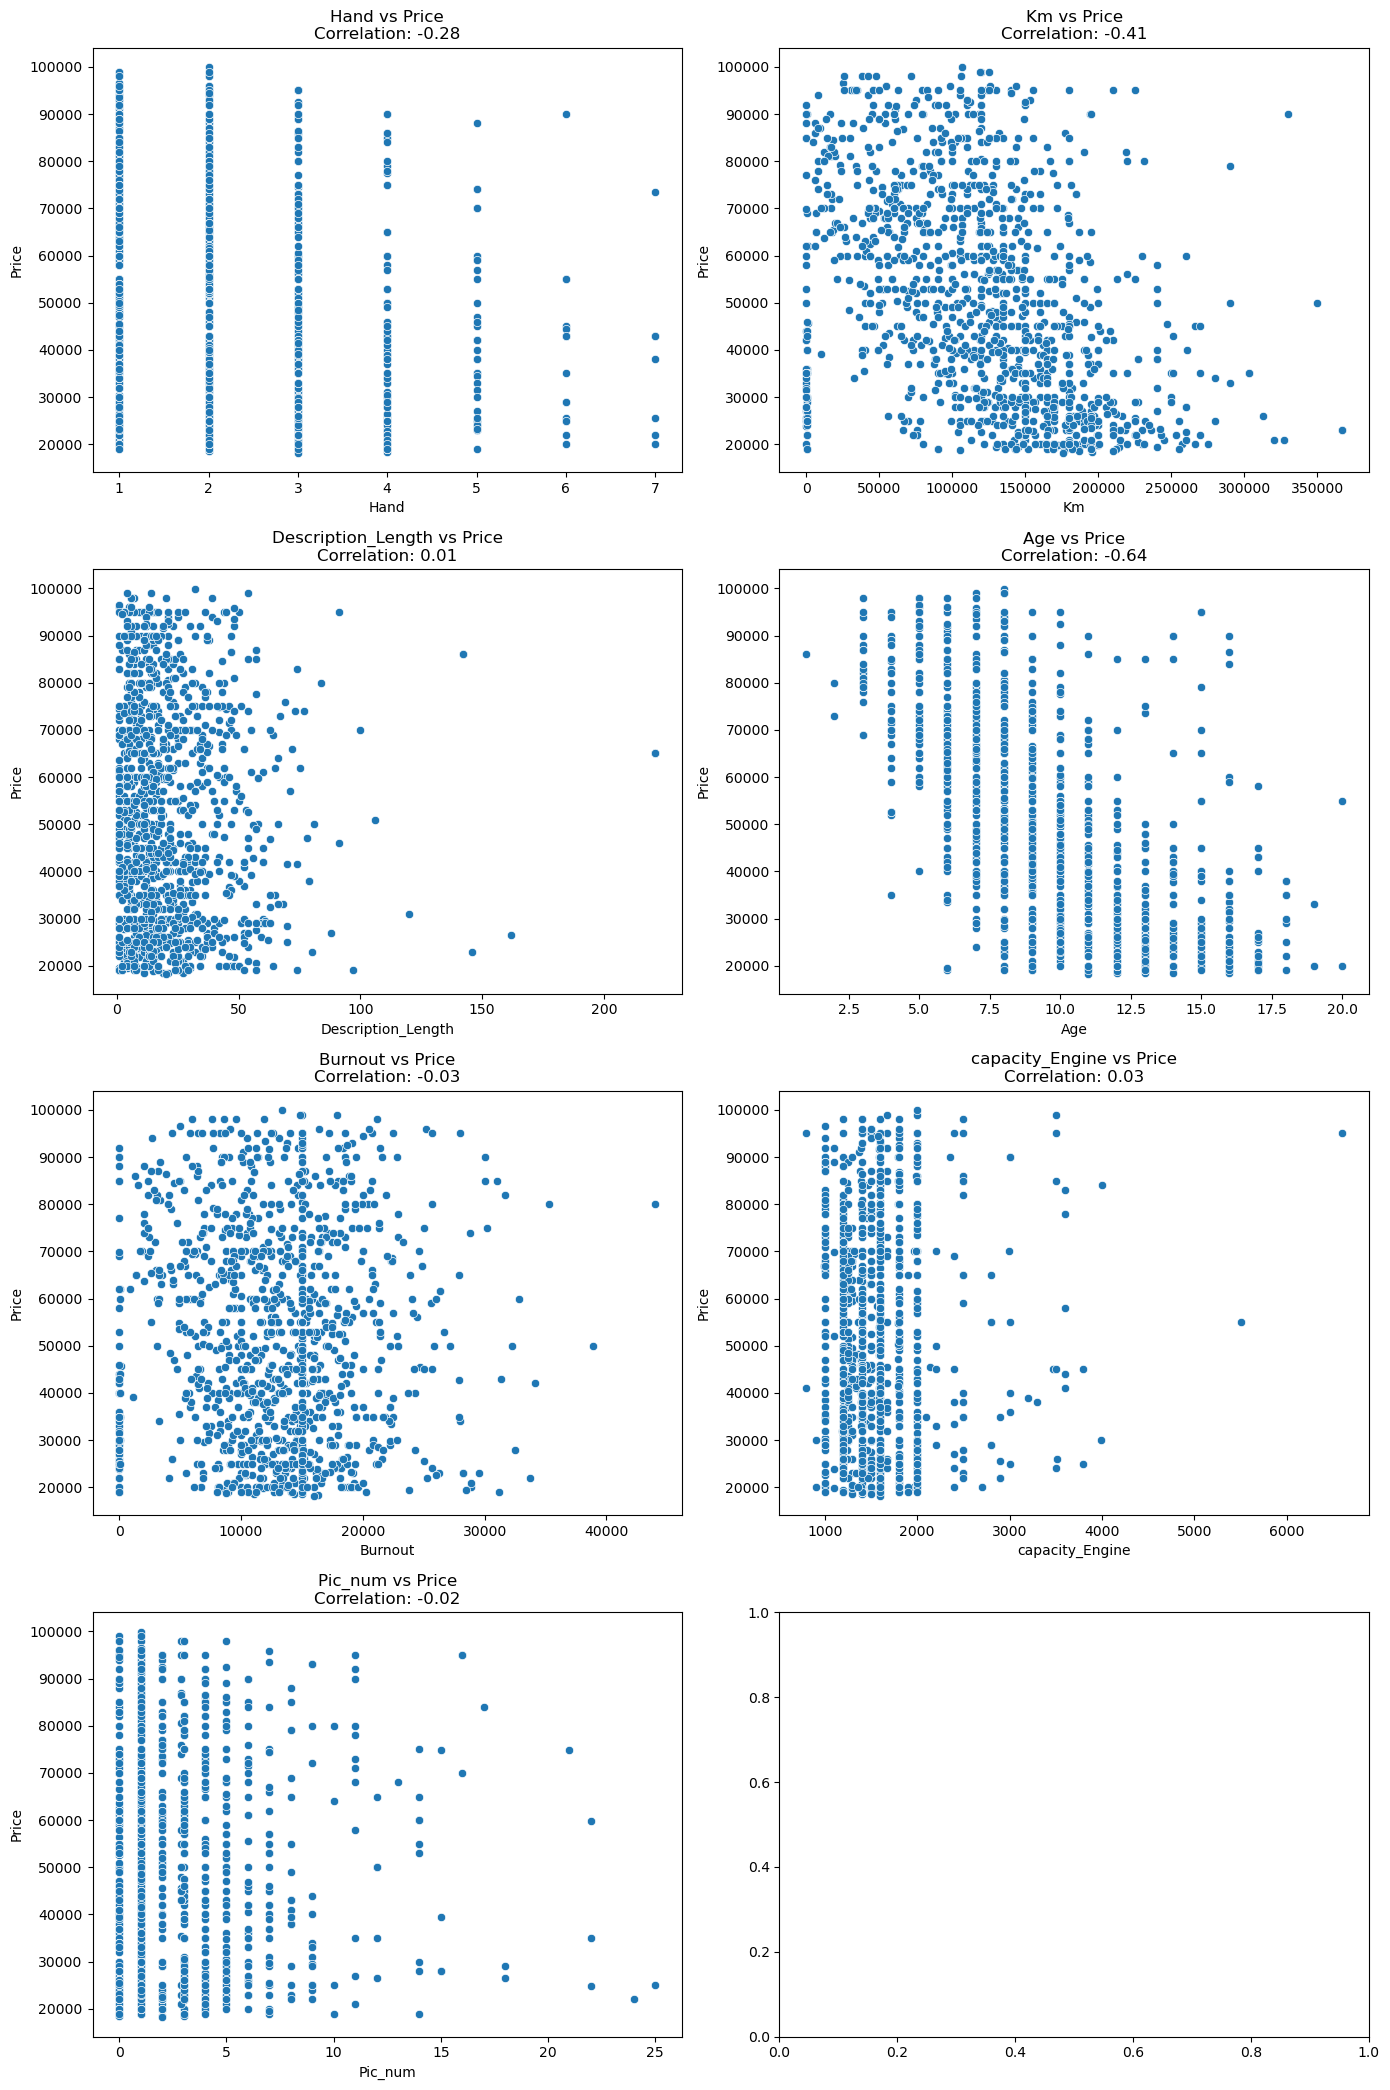

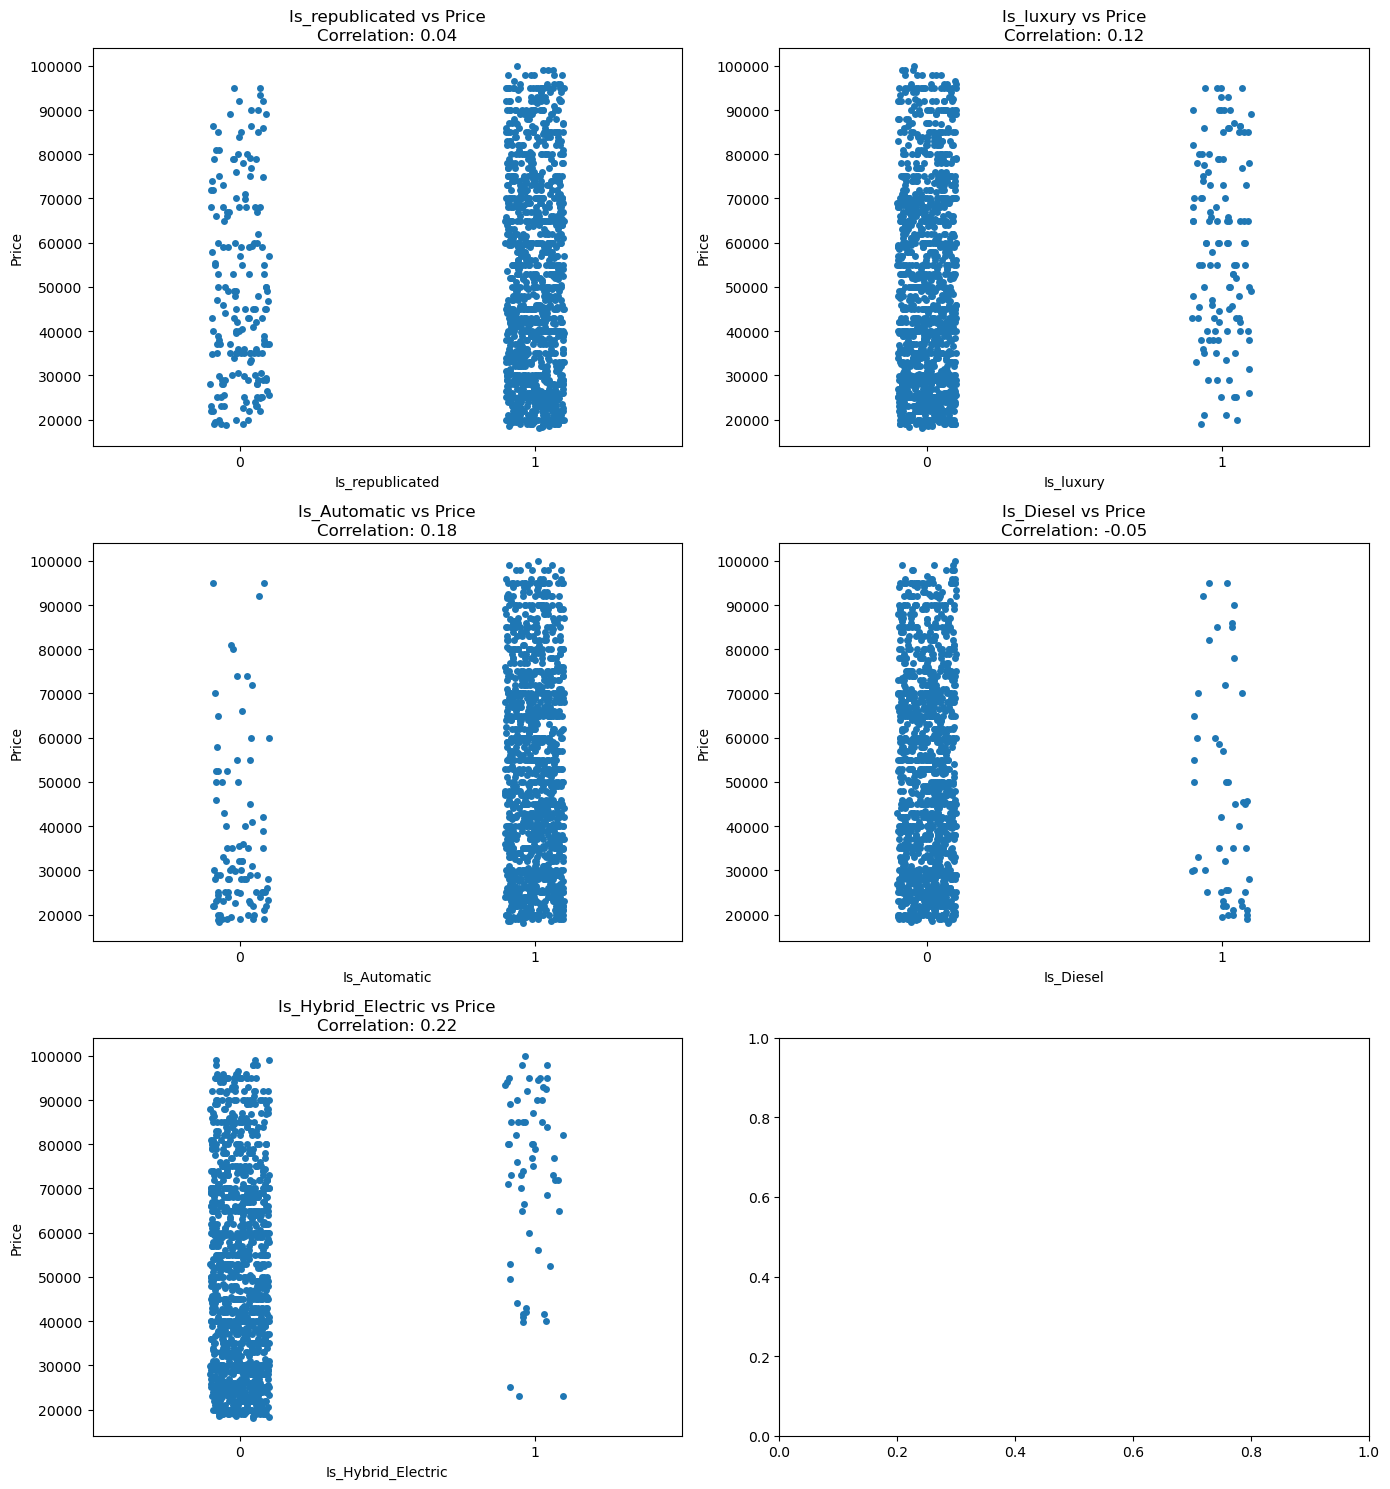

In [60]:
# Plot settings
def plot_side_by_side(data, features, plot_type='scatter'):
    num_features = len(features)
    fig, axes = plt.subplots(nrows=(num_features + 1) // 2, ncols=2, figsize=(14, num_features * 3))

    for i, feature in enumerate(features):
        row, col = divmod(i, 2)
        if plot_type == 'scatter':
            sns.scatterplot(data=data, x=feature, y='Price', ax=axes[row, col])
        elif plot_type == 'strip':
            sns.stripplot(data=data, x=feature, y='Price', jitter=True, ax=axes[row, col])
        
        correlation = data[[feature, 'Price']].corr().iloc[0, 1]
        axes[row, col].set_title(f'{feature} vs Price\nCorrelation: {correlation:.2f}')
        axes[row, col].set_xlabel(feature)
        axes[row, col].set_ylabel('Price')

    plt.tight_layout()
    plt.show()

# Scatter plots for numeric features vs. Price with correlation
plot_side_by_side(data, numeric_features, plot_type='scatter')

# Strip plots for binary features vs. Price with correlation
plot_side_by_side(data, binary_features, plot_type='strip')



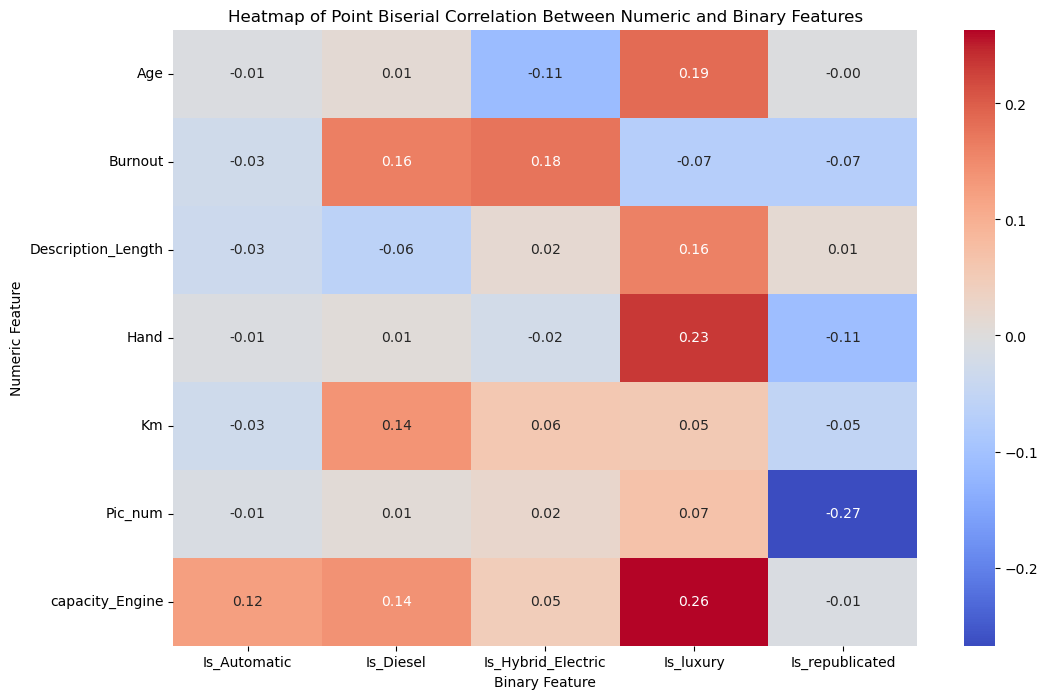

In [61]:
# Calculate point biserial correlation for each pair of numeric and binary features
correlation_dict = {}
for numeric in numeric_features:
    for binary in binary_features:
        correlation, p_value = pointbiserialr(data[binary], data[numeric])
        correlation_dict[(numeric, binary)] = correlation

# Convert the correlation dictionary to a DataFrame
correlation_df = pd.DataFrame.from_dict(correlation_dict, orient='index', columns=['Correlation'])

# Reset the index to separate numeric and binary feature columns
correlation_df.reset_index(inplace=True)
correlation_df[['Numeric Feature', 'Binary Feature']] = pd.DataFrame(correlation_df['index'].tolist(), index=correlation_df.index)
correlation_df.drop(columns=['index'], inplace=True)

# Pivot the DataFrame to get a heatmap format
correlation_pivot = correlation_df.pivot(index='Numeric Feature', columns='Binary Feature', values='Correlation')

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_pivot, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap of Point Biserial Correlation Between Numeric and Binary Features')
plt.show()


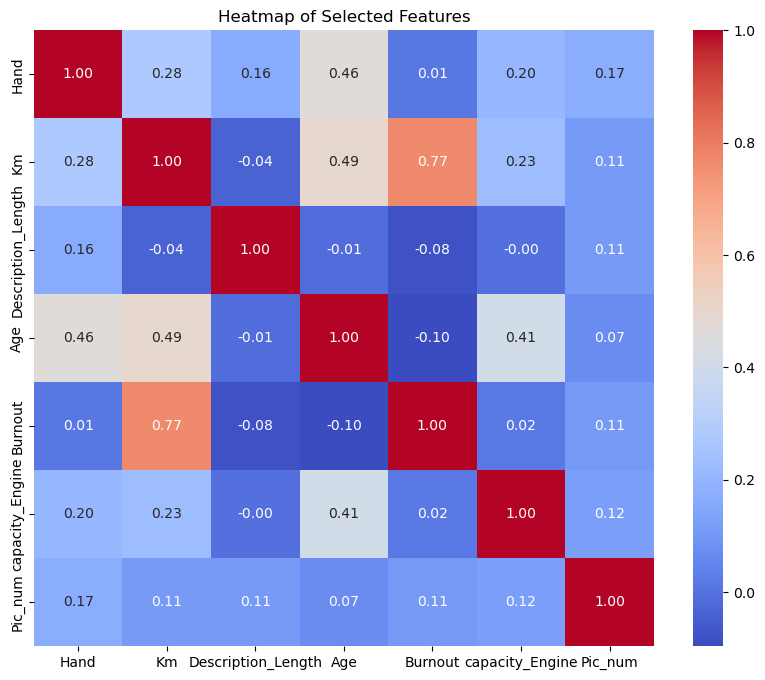

In [62]:
# Create a dataframe with only the selected features
selected_data = data[numeric_features]

# Plot heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = selected_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap of Selected Features')
plt.show()

* We will remove:
  *  Burnout - High correlation with Age, They depend on each other.
  *  Is_Diesel - Removed to avoid Multicollinearity.
  *  Description_Length - Low correlation and concern that it does not fulfill the regression assumptions.
  *  Pic_num -Low correlation. 

* VIF check

In [65]:
binary_features_VIF = ['Is_republicated', 'Is_luxury', 'Is_Automatic', 'Is_Hybrid_Electric']
numeric_features_VIF = ['Hand', 'Km', 'Age', 'capacity_Engine']

features = binary_features_VIF + numeric_features_VIF

# Prepare the feature set
X = data[features]

# Add a constant to the model (required for VIF calculation)
X = sm.add_constant(X)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Remove the constant term from the VIF DataFrame
vif_data = vif_data[vif_data["Feature"] != "const"]

# Print the VIF values
print("Variance Inflation Factor (VIF) for each feature:")
print(vif_data)


Variance Inflation Factor (VIF) for each feature:
              Feature       VIF
1     Is_republicated  1.019372
2           Is_luxury  1.126666
3        Is_Automatic  1.028882
4  Is_Hybrid_Electric  1.044822
5                Hand  1.333304
6                  Km  1.358445
7                 Age  1.795226
8     capacity_Engine  1.285336


* VIF checked 

## Building an external (global) `preprocessor` consisting of pipelines for imputing and scaling 

In [68]:
target = ['Price'] # Seperating target from the rest to attach it unique pipeline

# Specify our features by their types:
binary_features = ['Is_republicated', 'Is_luxury', 'Is_Automatic', 'Is_Hybrid_Electric']
numeric_features = ['Hand', 'Km', 'Age', 'capacity_Engine']
categorical_features = ['model']

In [69]:
# Create the preprocessor with imputers, encoders and scalers according to data type
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('scaler', RobustScaler())
        ]), numeric_features),
        ('bin', SimpleImputer(strategy='constant', fill_value=0), binary_features),
        ('cat', Pipeline([
            ('encoder', OneHotEncoder(handle_unknown='ignore',drop='if_binary', sparse=False)) ### OR sparse_output=False
        ]), categorical_features),
        ('target_scaler', RobustScaler(), target)
    ]
)

--------------------------------------------------

## Build and train Elastic-net regression model

In [72]:
data = original_data.copy()
train_data = prepare_data(data, fit=True)
train_data.head()

,Hand,Km,Age,capacity_Engine,Is_republicated,Is_luxury,Is_Automatic,Is_Hybrid_Electric,model_108,model_120i,...,model_קפצ'ור,model_קרוז,model_קרוסאובר,model_קרניבל,model_ראפיד,model_רומסטר,model_ריו,model_שירוקו,model_שרמנט,Price
0,0.0,0.241758,0.0,0.181818,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.076923
1,-0.5,-0.582418,-0.6,-0.545455,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.025641
2,-0.5,0.252747,1.0,-0.090909,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.653846
3,-0.5,-1.040659,-0.2,0.181818,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.384615
4,-0.5,-0.571429,0.6,-0.458182,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.282051


In [73]:
X = train_data.drop(columns = 'Price')
y = train_data.Price

model = ElasticNetCV(cv = 10, random_state=42)
model.fit(X, y)

ElasticNetCV(cv=10, random_state=42)

### Our model Called `model` 
#### While evaluating the model we must remember to rescale predictions before comparing to the y_test.

---

### Validation:
- We need to rescale our predictions back to original realistic scale:

In [77]:
target_scaler = preprocessor.named_transformers_.target_scaler
train_pred = model.predict(X)
train_pred = target_scaler.inverse_transform(train_pred.reshape(-1, 1))

In [78]:
y = target_scaler.inverse_transform([y])[0]

In [79]:
rmse = mean_squared_error(y, train_pred) ** 0.5
mse = mean_squared_error(y, train_pred)
mae = mean_absolute_error(y, train_pred)
r2 = r2_score(y, train_pred)

print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R-squared Score: {r2}')

Root Mean Squared Error: 9849.266804783496
Mean Squared Error: 97008056.59181008
Mean Absolute Error: 7244.09615943441
R-squared Score: 0.8041615832439184


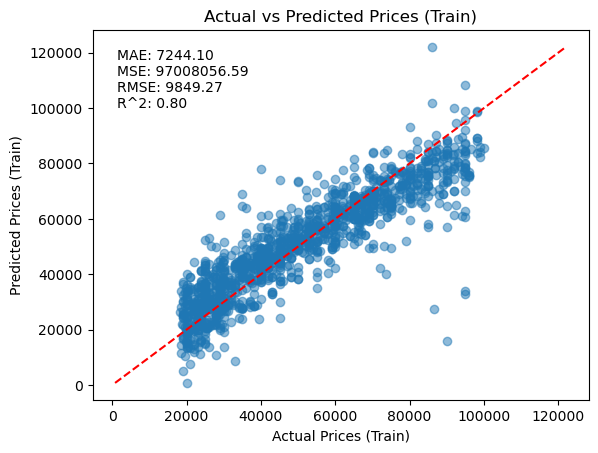

In [80]:
# plt.subplot(1, 2, 1)
plt.scatter(y, train_pred, alpha=0.5)
plt.plot([min(train_pred), max(train_pred)], [min(train_pred), max(train_pred)], 'r', linestyle='--')
plt.xlabel('Actual Prices (Train)')
plt.ylabel('Predicted Prices (Train)')
plt.title('Actual vs Predicted Prices (Train)')
plt.text(0.05, 0.95, f'MAE: {mae:.2f}\nMSE: {mse:.2f}\nRMSE: {rmse:.2f}\nR^2: {r2:.2f}', 
         transform=plt.gca().transAxes, verticalalignment='top');

### 10-Fold Cross-validation scores:

In [82]:
ttr = TransformedTargetRegressor(regressor = model, transformer = RobustScaler()) # For properly scaling `y`.
cv = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 1) # Define repeated cross-validation increasing reliability

# Define scoring metrics
scoring = {
    'root_mean_squared_error': 'neg_root_mean_squared_error',
    'mean_absolute_error': 'neg_mean_absolute_error',
    'mean_squared_error': 'neg_mean_squared_error',
    'r2': 'r2'
}

cv_results = cross_validate(ttr, X, y, cv=cv, scoring=scoring, n_jobs=-1)

for metric in scoring.keys():
    scores = cv_results[f'test_{metric}']
    mean_score = -scores.mean() if 'neg_' in scoring.get(metric) else scores.mean()
    print(f'{BOLD}{metric}{RESET}: {mean_score:.2f}')


root_mean_squared_error: 11608.37
mean_absolute_error: 8326.11
mean_squared_error: 136555795.08
r2: 0.72


### Features significants:

* The Value 

In [85]:
feature_names = X.columns.tolist()
coefficients = model.coef_

df = pd.DataFrame({'feature': feature_names, 'coefficient': coefficients})
df['importance'] = np.abs(df['coefficient']) # Calculate the absolute value of coefficients to determine importance

model_features = df[df['feature'].str.startswith('model_')] # Separate `model_` features
other_features = df[~df['feature'].str.startswith('model_')]

# Calculate mean coefficient and mean importance for `model_` features
model_mean_coefficient = model_features['coefficient'].mean()
model_mean_importance = model_features['importance'].mean()

# Create a new DataFrame for the aggregated `model` feature
model_aggregated = pd.DataFrame({
    'feature': ['model_aggregated'],
    'coefficient': [model_mean_coefficient],
    'importance': [abs(model_mean_coefficient)]})

# Combine the aggregated `model` feature with other features
df_combined = pd.concat([other_features, model_aggregated], ignore_index=True)
df_sorted = df_combined.sort_values('importance', ascending=False).reset_index(drop=True)
pd.DataFrame(df_sorted).drop(columns = 'importance')

,feature,coefficient
0,Age,-0.643292
1,Is_luxury,0.408698
2,Is_Automatic,0.138131
3,capacity_Engine,0.135142
4,Km,-0.124126
5,Is_Hybrid_Electric,0.107628
6,Is_republicated,0.059139
7,Hand,-0.037479
8,model_aggregated,0.021769


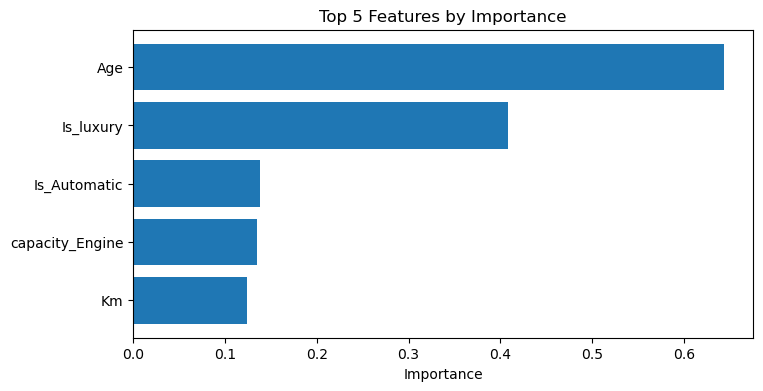

In [86]:
# Filter out zero coefficients
df_nonzero = df_sorted[df_sorted['importance'] > 0]

# Plot the top 5 features by importance
top_n = 5
plt.figure(figsize=(8, 4))
plt.barh(df_nonzero['feature'][:top_n], df_nonzero['importance'][:top_n])
plt.gca().invert_yaxis()
plt.xlabel('Importance')
plt.title('Top 5 Features by Importance')
plt.show()

In [87]:
df_combined['effect'] = df_combined['coefficient'].apply(lambda x: 'positive' if x > 0 else 'negative')
# Normalize the importance to get percentages
total_importance = df_combined['importance'].sum()
df_combined['importance_percentage'] = (df_combined['importance'] / total_importance) * 100

# Sort the DataFrame by importance percentage
df_sorted = df_combined.sort_values('importance_percentage', ascending=False).reset_index(drop=True)

# Display the final DataFrame
df_final = df_sorted.drop(columns='importance')
df_final.head()

,feature,coefficient,effect,importance_percentage
0,Age,-0.643292,negative,38.396271
1,Is_luxury,0.408698,positive,24.393995
2,Is_Automatic,0.138131,positive,8.244642
3,capacity_Engine,0.135142,positive,8.066218
4,Km,-0.124126,negative,7.408754


---

---

## Inner check with data split and using modified function:
* The only difference between the action is removing the `Price` target from the input.

In [91]:
data = original_data.copy()

* Split **before** preperation process

In [93]:

#X = data.drop(columns = 'Price')
#y = data.Price

# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#X_train['Price'] = y_train # Connecting back for activating our preperation function
#X_test['Price'] = y_test
#train = prepare_data(X_train, fit = True)
#test = prepare_data(X_test)
#X_train = train.drop(columns = ['Price'])
#X_test = test.drop(columns = ['Price'])
#y_train = train.Price
#y_test = test.Price

#Inner_model = ElasticNetCV(cv = 10, random_state=82)
#Inner_model.fit(X_train, y_train)
#y_pred = Inner_model.predict(X_test)

# Back to prices:
#y_pred = target_scaler.inverse_transform(np.array(y_pred).reshape(-1, 1))
#rmse = mean_squared_error(y_pred, y_test) ** 0.5
#mse = mean_squared_error(y_pred, y_test)
#mae = mean_absolute_error(y_pred, y_test)
#r2 = r2_score(y_pred, y_test)

#print(f'{BOLD}Root Mean Squared Error:{RESET} {rmse}')
#print(f'{BOLD}Mean Squared Error:{RESET} {mse}')
#print(f'{BOLD}Mean Absolute Error:{RESET} {mae}')
#print(f'{BOLD}R-squared Score:{RESET} {r2}')
#plt.scatter(y_test, y_pred, alpha=0.5)
#plt.plot([min(y_pred), max(y_pred)], [min(y_pred), max(y_pred)], 'r', linestyle='--')
#plt.xlabel('Actual Prices (test)')
#plt.ylabel('Predicted Prices (test)')
#plt.title('Actual vs Predicted Prices (test)')
#plt.text(0.05, 0.95, f'MAE: {mae:.2f}\nMSE: {mse:.2f}\nRMSE: {rmse:.2f}\nR^2: {r2:.2f}', 
#         transform=plt.gca().transAxes, verticalalignment='top');

---